# Gradient Boost

최고 성능 하이퍼파라미터 조합 이용 모델 학습 헬퍼 함수 (SMOTENC 적용 여부 비교를 위함)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from joblib import dump

def model_train_test(df, save):
    X = df.drop(['is_churned'], axis=1)
    y = df['is_churned']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 최고 성능 하이퍼 파라미터 조합 (학습률 0.13으로 할 때가 좀 더 좋음)
    gb_clf = GradientBoostingClassifier(learning_rate=0.13, max_depth=9, n_estimators= 550, random_state=42)

    gb_clf.fit(X_train, y_train)

    y_pred = gb_clf.predict(X_test)
    y_proba = gb_clf.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.3, 0.7, 0.01)
    best_thresh, best_macro_f1 = 0.5, 0

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
        f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
        macro_f1 = (f1_0 + f1_1) / 2

        if macro_f1 > best_macro_f1:
            best_macro_f1, best_thresh = macro_f1, t

    y_pred_best = (y_proba >= best_thresh).astype(int)

    print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
    print('report', classification_report(y_test, y_pred_best))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # 변수 중요도 분석 (permutation_importance)
    print("\nPermutation Importance on Test Set:")
    perm_importance = permutation_importance(gb_clf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

    perm_df = pd.DataFrame({'feature': X_test.columns, 'importance_mean': perm_importance.importances_mean})
    perm_df = perm_df.sort_values(by='importance_mean', ascending=False)

    top_n = 15
    # 중요도 내림차순 정렬 후 상위 n개 선택
    perm_df_top = perm_df.sort_values(by='importance_mean', ascending=False).head(top_n)
    # 그래프는 보통 가독성 위해 오름차순으로 그리니 다시 정렬
    perm_df_top = perm_df_top.sort_values(by='importance_mean', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(perm_df_top['feature'], perm_df_top['importance_mean'], color='skyblue')
    plt.xlabel('Permutation Importance (Mean)')
    plt.title(f'Top {top_n} Feature Importances (Permutation Importance)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # save가 True일 때만 모델 저장
    if save:
        dump(gb_clf, 'best_model.joblib')
        

In [6]:
ysyc = pd.read_csv('./data_ml/yes_SMOTENC.csv')
nsyc = pd.read_csv('./data_ml/no_SMOTENC.csv')

## SMOTENC 적용

좁은 범위로 GridSearchCV 재시도

In [11]:
from sklearn.model_selection import GridSearchCV

X = ysyc.drop(['is_churned'], axis=1)
y = ysyc['is_churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

params ={
    "learning_rate": [0.11, 0.12, 0.13],
    "max_depth": [8, 9, 10],
    "n_estimators": [450, 500, 550],
}

gb_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_clf, param_grid=params, cv=5, scoring='f1', n_jobs=-1, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

best_index = grid_search.best_index_
mean_f1 = grid_search.cv_results_['mean_test_score'][best_index]
std_f1 = grid_search.cv_results_['std_test_score'][best_index]

print(f"Best model CV mean F1: {mean_f1:.4f} (+/- {std_f1:.4f})")


# 최적 모델로 예측
best_gb = grid_search.best_estimator_
y_proba = best_gb.predict_proba(X_test)[:, 1]


# threshold 탐색
thresholds = np.arange(0.3, 0.71, 0.01)
best_thresh, best_macro_f1 = 0.5, 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_0 = f1_score(y_test, y_pred_t, pos_label=0)
    f1_1 = f1_score(y_test, y_pred_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2

    if macro_f1 > best_macro_f1:
        best_macro_f1, best_thresh = macro_f1, t

# 최적 threshold 적용
y_pred_best = (y_proba >= best_thresh).astype(int)

print('best parameters', grid_search.best_params_)
print(f'Best threshold: {best_thresh:.2f}, Macro F1: {best_macro_f1:.4f}')
print('report', classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best model CV mean F1: 0.8762 (+/- 0.0032)
best parameters {'learning_rate': 0.12, 'max_depth': 8, 'n_estimators': 550}
Best threshold: 0.37, Macro F1: 0.8870
report               precision    recall  f1-score   support

           0       0.89      0.88      0.89      2487
           1       0.88      0.90      0.89      2487

    accuracy                           0.89      4974
   macro avg       0.89      0.89      0.89      4974
weighted avg       0.89      0.89      0.89      4974



Best threshold: 0.32, Macro F1: 0.8900
report               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2487
           1       0.88      0.90      0.89      2487

    accuracy                           0.89      4974
   macro avg       0.89      0.89      0.89      4974
weighted avg       0.89      0.89      0.89      4974



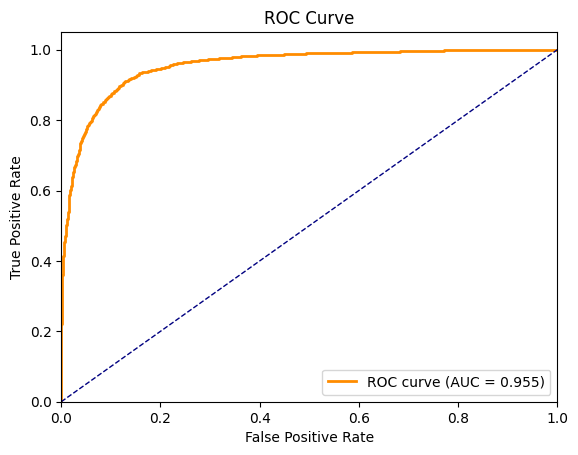


Permutation Importance on Test Set:


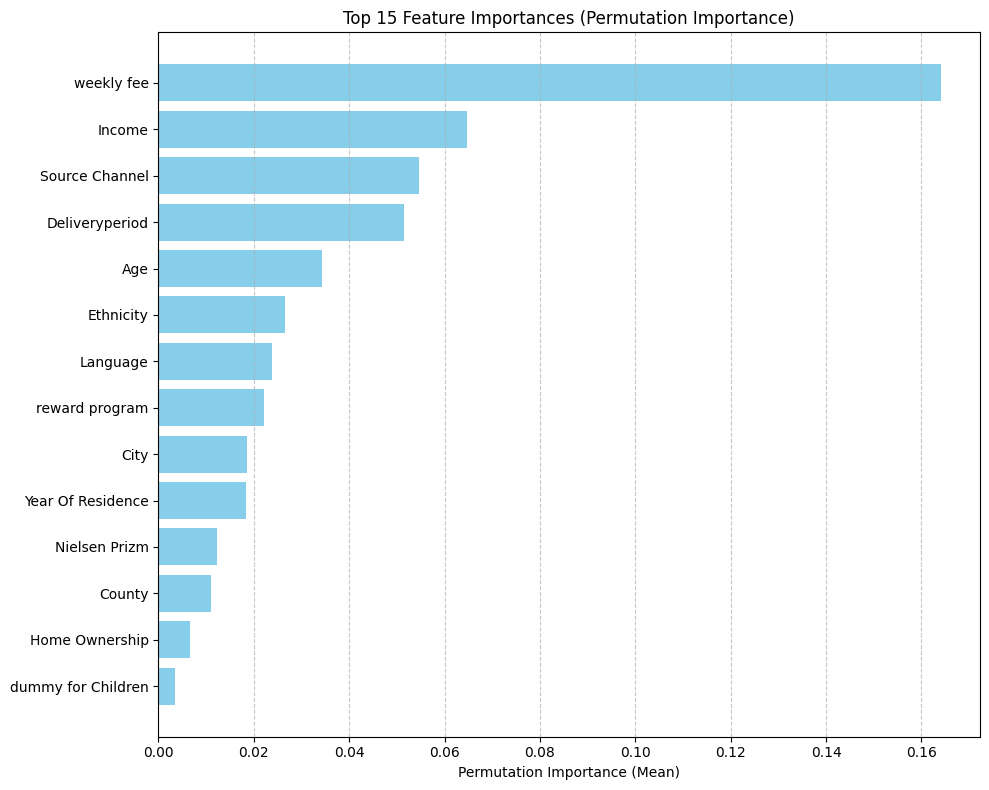

In [ ]:
# 최고 성능 모델 최종 학습 확인 후 저장 O
model_train_test(ysyc, True)

---

## SMOTENC 미적용

Best threshold: 0.62, Macro F1: 0.7090
report               precision    recall  f1-score   support

           0       0.62      0.44      0.51       601
           1       0.87      0.94      0.90      2487

    accuracy                           0.84      3088
   macro avg       0.75      0.69      0.71      3088
weighted avg       0.82      0.84      0.83      3088



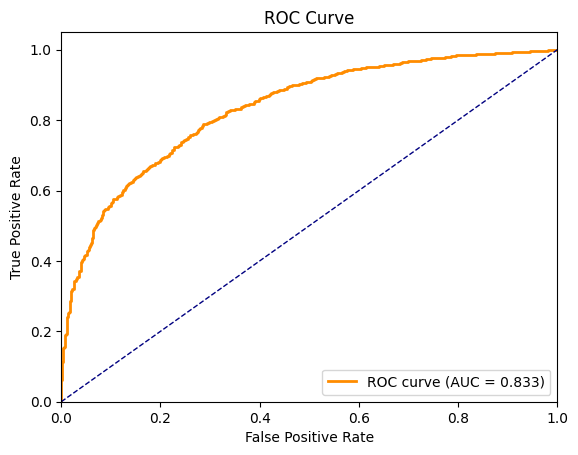


Permutation Importance on Test Set:


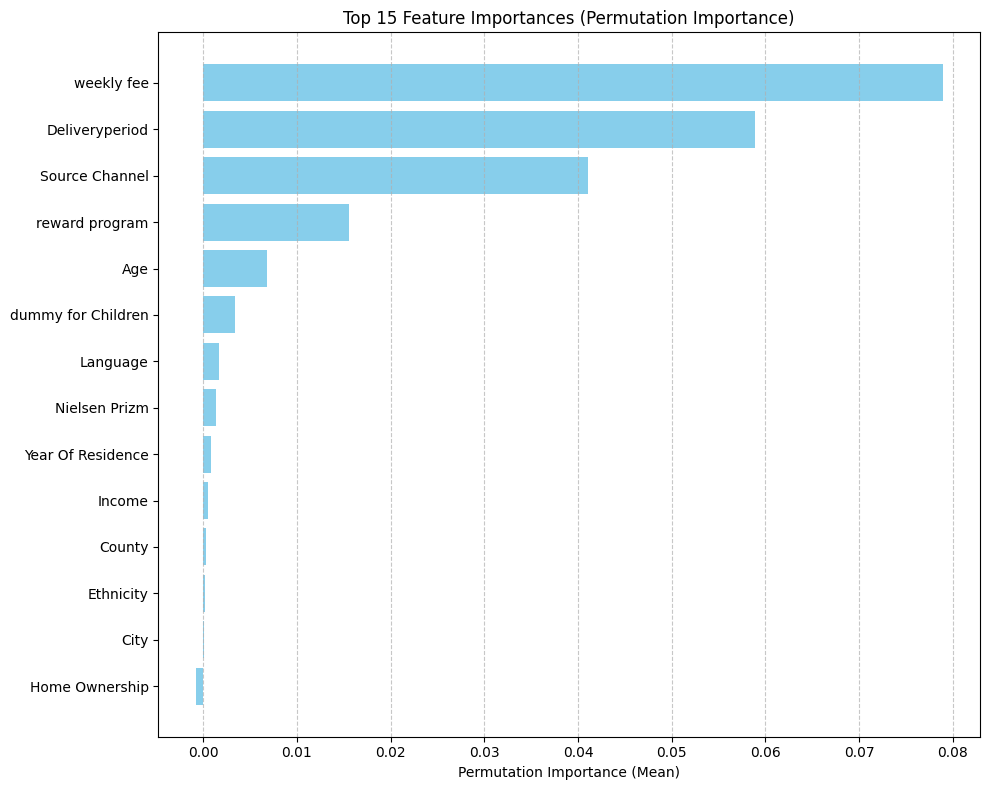

In [8]:
# 모델 저장X
model_train_test(nsyc, False)